In [1]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 16501832674975896360
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 6586313605
locality {
  bus_id: 1
  links {
  }
}
incarnation: 12734386188324889277
physical_device_desc: "device: 0, name: GeForce RTX 2070 SUPER, pci bus id: 0000:01:00.0, compute capability: 7.5"
]


In [1]:
from __future__ import print_function
import tensorflow.compat.v1 as tf
import tensorflow.keras as keras
from tensorflow.keras.datasets import mnist
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D
from tensorflow.keras import backend as K

gpu_options = tf.GPUOptions(per_process_gpu_memory_fraction=0.75, allow_growth=True)
sess = tf.InteractiveSession(config=tf.ConfigProto(gpu_options=gpu_options))
tf.keras.backend.set_session(sess)

In [2]:
# 定義梯度下降批量
batch_size = 128
# 定義分類數量
num_classes = 10
# 定義訓練週期
epochs = 12

# 定義圖像寬、高
img_rows, img_cols = 28, 28

# 載入 MNIST 訓練資料
(x_train, y_train), (x_test, y_test) = mnist.load_data()

# 保留原始資料，供 cross tab function 使用
y_test_org = y_test

# channels_first: 色彩通道(R/G/B)資料(深度)放在第2維度，第3、4維度放置寬與高
if K.image_data_format() == 'channels_first':
    x_train = x_train.reshape(x_train.shape[0], 1, img_rows, img_cols)
    x_test = x_test.reshape(x_test.shape[0], 1, img_rows, img_cols)
    input_shape = (1, img_rows, img_cols)
else: # channels_last: 色彩通道(R/G/B)資料(深度)放在第4維度，第2、3維度放置寬與高
    x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, 1)
    x_test = x_test.reshape(x_test.shape[0], img_rows, img_cols, 1)
    input_shape = (img_rows, img_cols, 1)

# 轉換色彩 0~255 資料為 0~1
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255

# y 值轉成 one-hot encoding
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

In [3]:
import numpy as np
print(np.shape(x_train))
print(np.shape(y_train))
print(np.shape(x_test))
print(np.shape(y_test))
input_shape

(60000, 28, 28, 1)
(60000, 10)
(10000, 28, 28, 1)
(10000, 10)


(28, 28, 1)

In [11]:
# 建立簡單的線性執行的模型
model = Sequential()
# 建立卷積層，filter=16,即 output space 的深度, Kernal Size: 5x5, activation function 採用 relu
model.add(Conv2D(filters=16, 
                 kernel_size=(5, 5),
                 padding="same",
                 activation='relu',
                 input_shape=input_shape))
# 建立池化層，池化大小=2x2，取最大值
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(filters=36, 
                 kernel_size=(5, 5),
                 padding="same",
                 activation='relu',
                 input_shape=input_shape))

model.add(MaxPooling2D(pool_size=(2, 2)))

# Dropout層隨機斷開輸入神經元，用於防止過度擬合，斷開比例:0.25
model.add(Dropout(0.25))

# Flatten層把多維的輸入一維化，常用在從卷積層到全連接層的過渡。
model.add(Flatten())

# 全連接層: 128個output
model.add(Dense(128, activation='relu'))

# Dropout層隨機斷開輸入神經元，用於防止過度擬合，斷開比例:0.25
model.add(Dropout(0.25))

# 使用 softmax activation function，將結果分類
model.add(Dense(num_classes, activation='softmax'))

# 編譯: 選擇損失函數、優化方法及成效衡量方式
model.compile(loss="categorical_crossentropy",
              optimizer="adam",
              metrics=['accuracy'])

print(model.summary()) 

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_10 (Conv2D)           (None, 28, 28, 16)        416       
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 14, 14, 16)        0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 14, 14, 36)        14436     
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 7, 7, 36)          0         
_________________________________________________________________
dropout_10 (Dropout)         (None, 7, 7, 36)          0         
_________________________________________________________________
flatten_5 (Flatten)          (None, 1764)              0         
_________________________________________________________________
dense_10 (Dense)             (None, 128)              

In [26]:
from tensorflow.keras.callbacks import Callback
import numpy as np
from sklearn.metrics import confusion_matrix
### Callbacks
class SensitivitySpecificityCallback(Callback):
    def on_epoch_end(self, epoch, logs=None):
        if epoch:
            print("=============================acda========================================")
            print(vars(self))
            x_test, y_test = self.validation_data[0], self.validation_data[1]
            predictions = self.model.predict(x_test)
            output_sensitivity_specificity(epoch, predictions, y_test)


def output_sensitivity_specificity(epoch, predictions, y_test, mode='binary'):
    if mode == 'binary':
        # determine positive class predictions
        idx = predictions >= 0.5
        predictions = np.zeros(predictions.shape)
        predictions[idx] = 1
        # no need to modify y_test since it consists of zeros and ones already
    else:
        y_test = np.argmax(y_test, axis=-1)
        predictions = np.argmax(predictions, axis=-1)

    c = confusion_matrix(y_test, predictions)
    print('Confusion matrix:\n', c)
    print('[{:03d}] sensitivity'.format(epoch), c[0, 0] / (c[0, 1] + c[0, 0]))
    print('[{:03d}] specificity'.format(epoch), c[1, 1] / (c[1, 1] + c[1, 0]))

In [27]:
# https://www.deepideas.net/unbalanced-classes-machine-learning/
# from tensorflow.keras.optimizers import RMSprop

# def sensitivity(y_true, y_pred):
#     true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
#     possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
#     return true_positives / (possible_positives + K.epsilon())

# def specificity(y_true, y_pred):
#     true_negatives = K.sum(K.round(K.clip((1-y_true) * (1-y_pred), 0, 1)))
#     possible_negatives = K.sum(K.round(K.clip(1-y_true, 0, 1)))
#     return true_negatives / (possible_negatives + K.epsilon())

# model.compile(
#     loss='binary_crossentropy',
#     optimizer=RMSprop(0.001),
#     metrics=[sensitivity, specificity, 'accuracy']
# )

In [29]:
# 進行訓練, 訓練過程會存在 train_history 變數中
train_history = model.fit(x_train, y_train,
                          batch_size=batch_size,
                          epochs=epochs,
                          verbose=1,
                          validation_data=(x_test, y_test),
                          callbacks=[SensitivitySpecificityCallback()])
# 顯示損失函數、訓練成果(分數)
score = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

TypeError: __init__() takes 1 positional argument but 2 were given

In [15]:
# https://www.tensorflow.org/api_docs/python/tf/keras/metrics/SensitivityAtSpecificity

# https://blog.csdn.net/weixin_43790560/article/details/96483272
# acc, acc_op = tf.metrics.accuracy(labels=tf.argmax(labels, 1), 
#                                   predictions=tf.argmax(logits,1))

# acc, acc_op=tf.metrics.accuracy(labels=y_train, predictions=y_train)
# pre, pre_op=tf.metrics.precision(labels=y_train, predictions=y_train)
# sen, sen_op=tf.metrics.recall(labels=y_train, predictions=y_train)
# spe, spe_op=tf.metrics.specificity_at_sensitivity(labels=x_train, predictions=y_train, sensitivity=0.5)

RuntimeError: The Session graph is empty.  Add operations to the graph before calling run().

In [13]:
import matplotlib.pyplot as plt

def show_train_history(h, t, v):
    plt.plot(h.history[t])
    plt.plot(h.history[v])
    plt.title('Train History')
    plt.xlabel('Epoch')
    plt.ylabel(t)
    plt.legend(['train', 'validation'], loc='upper left')
    plt.show()

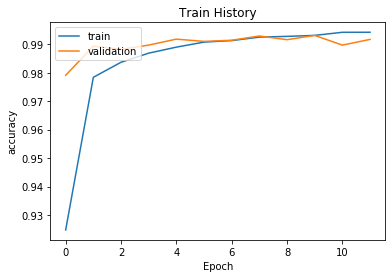

In [16]:
show_train_history(train_history, 'accuracy', 'val_accuracy')

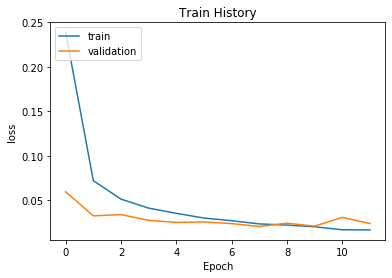

In [17]:
show_train_history(train_history, 'loss', 'val_loss')

In [ ]:
# 模型結構存檔
from keras.models import model_from_json
json_string = model.to_json()
with open("cnn.config", "w") as text_file:
    text_file.write(json_string)

    
# 模型訓練結果存檔
model.save_weights("cnn.weight")

In [18]:
# 計算『混淆矩陣』(Confusion Matrix)，顯示測試集分類的正確及錯認總和數
import pandas as pd 
predictions = model.predict_classes(x_test) 
pd.crosstab(y_test_org, predictions, rownames=['實際值'], colnames=['預測值'])

預測值,0,1,2,3,4,5,6,7,8,9
實際值,,,,,,,,,,
0,977,0,1,0,0,0,0,0,1,1
1,0,1128,1,1,0,1,2,0,1,1
2,0,0,1029,0,0,0,0,3,0,0
3,0,0,1,1000,0,3,0,2,3,1
4,0,0,1,0,968,0,1,0,1,11
5,2,0,0,5,0,883,1,0,0,1
6,5,2,1,0,1,0,949,0,0,0
7,0,2,2,1,0,0,0,1018,1,4
8,2,0,2,1,0,1,0,1,965,2


In [1]:
def solve_cudnn_error():
    gpus = tf.config.experimental.list_physical_devices('GPU')
    if gpus:
        try:
            # Currently, memory growth needs to be the same across GPUs
            for gpu in gpus:
                tf.config.experimental.set_memory_growth(gpu, True)
            logical_gpus = tf.config.experimental.list_logical_devices('GPU')
            print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
        except RuntimeError as e:
            # Memory growth must be set before GPUs have been initialized
            print(e)

In [2]:
solve_cudnn_error()

NameError: name 'tf' is not defined